In [ ]:
import sys
from pathlib import Path
import pandas as pd
from datasetsforecast.m3 import M3
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
import importlib
from tabulate import tabulate

import sys
import os

project_root = os.getcwd()
print(f"Using project root: {project_root}")

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path.")
else:
    print(f"Project root already in sys.path.")
    
from src.metrics import Pelt, STLFeatures, ACF_Features, LinearRegression

In [ ]:
print(f"\nLoading M3 Monthly data using datasetsforecast...")

# Define the data directory relative to the project root
if 'project_root' not in locals():
     current_dir = os.getcwd()
     project_root = os.path.dirname(current_dir)
     print(f"Defining project_root as: {project_root}")

data_dir = os.path.join(project_root, 'data', 'm3_monthly')

os.makedirs(data_dir, exist_ok=True)
print(f"Ensuring data directory exists/created: '{data_dir}'")

loaded_data = M3.load(directory=data_dir, group='Monthly')

Y_df = None # Initialize Y_df
if isinstance(loaded_data, (list, tuple)) and len(loaded_data) > 0:
    Y_df = loaded_data[0]
elif isinstance(loaded_data, pd.DataFrame):
    Y_df = loaded_data
else:
    print(f"Warning: Unexpected data type loaded: {type(loaded_data)}. Assigning None.")

if Y_df is not None:
    print("Data loaded successfully.")
    print(f"DataFrame shape: {Y_df.shape}")
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    print("DataFrame 'ds' column converted to datetime.")
    DATA_LOADED = True
else:
    print("Failed to load data into DataFrame.")
    DATA_LOADED = False

In [ ]:
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
expected_end = "EasyTest"
if not project_root.endswith(expected_end):
     print(f"WARNING: Calculated project root '{project_root}' might be incorrect based on CWD '{current_dir}'. Adjust path logic if needed.")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")
else:
     print(f"Project root already in sys.path: {project_root}")

print("\nDynamically importing and running analysis function from testing/easytest_metrics.py...")

calculated_extremes = None
custom_analysis_func = None
MODULE_PATH = "testing.easytest_metrics"
FUNCTION_NAME = "test_easytest_metrics"

try:
    custom_module = importlib.import_module(MODULE_PATH)
    custom_analysis_func = getattr(custom_module, FUNCTION_NAME)
    print(f"Successfully imported function '{FUNCTION_NAME}' from module '{MODULE_PATH}'.")
    calculated_extremes = custom_analysis_func()
    print("Analysis function completed.")
except ModuleNotFoundError:
    print(f"ERROR: Could not find module '{MODULE_PATH}'.")
    print("Check if 'testing/__init__.py' and 'testing/easytest_metrics.py' exist and project root was added correctly to sys.path.")
    import pprint
    print("Current sys.path:")
    pprint.pprint(sys.path)
except ImportError as e:
    print(f"ERROR: Could not import module '{MODULE_PATH}'. Potentially an error within the module itself? Details: {e}")
except AttributeError:
    print(f"ERROR: Could not find function '{FUNCTION_NAME}' within module '{MODULE_PATH}'. Check function name.")
except Exception as e:
    print(f"ERROR: Running {FUNCTION_NAME} failed: {e}")

extreme_datasets_info = None
CALCULATORS_DEFINED = False

required_classes_exist = ('Pelt' in locals() and
                          'STLFeatures' in locals() and
                          'ACF_Features' in locals() and
                          'LinearRegression' in locals())

if required_classes_exist and calculated_extremes:
    print("Instantiating metric calculators...")
    pelt_calculator = Pelt()
    stl_calculator = STLFeatures(freq=12)
    acf_calculator = ACF_Features(freq=12)
    lr_calculator = LinearRegression()
    print("Metric calculators instantiated.")

    print("Mapping dynamically calculated extreme datasets...")
    temp_extreme_info = {}
    feature_keys_from_script = [
        "Pelt_Num_Breakpoints", "STL_Trend_Strength", "ACF_FirstLag",
        "LinearRegression_Slope", "LinearRegression_R2"
    ]


    all_keys_found = True
    for key in feature_keys_from_script:
        if key not in calculated_extremes:
            print(f"Warning: Key '{key}' not found in calculated_extremes dictionary.")
            all_keys_found = False
            continue

        extreme_pair = calculated_extremes.get(key, {})
        low_id = extreme_pair.get('lowest', (None, None))[0]
        high_id = extreme_pair.get('highest', (None, None))[0]

        if low_id is None or high_id is None:
             print(f"Warning: Missing low or high ID for feature '{key}'. Skipping.")
             all_keys_found = False
             continue

        if "Pelt" in key:
            calculator = pelt_calculator
            params = {"pen": None}
        elif "STL" in key:
            calculator = stl_calculator
            params = {}
        elif "ACF" in key:
            calculator = acf_calculator
            params = {}
        elif "LinearRegression" in key:
            calculator = lr_calculator
            params = {}
        else:
            print(f"Warning: No calculator defined for key '{key}'. Skipping.")
            all_keys_found = False
            continue

        temp_extreme_info[key] = {
            "low_id": low_id,
            "high_id": high_id,
            "calculator": calculator,
            "params": params
        }

    if all_keys_found and temp_extreme_info:
        extreme_datasets_info = temp_extreme_info
        print("Extreme dataset IDs and metric calculators mapped successfully.")
        CALCULATORS_DEFINED = True
    else:
         print("Failed to map all extreme datasets due to missing keys or IDs.")

elif not required_classes_exist:
    print("Skipping definition: Custom metric classes not imported correctly.")
elif not calculated_extremes:
    print("Skipping definition: Failed to calculate extremes from script.")

## Pelt_Num_Breakpoints

This feature detects the number of points where the trend changes.  
**Low value:** The trend has few/none shifting points, and is constant through time.  
**High value:** The trend is constantly shifting, provoking many structural changes.

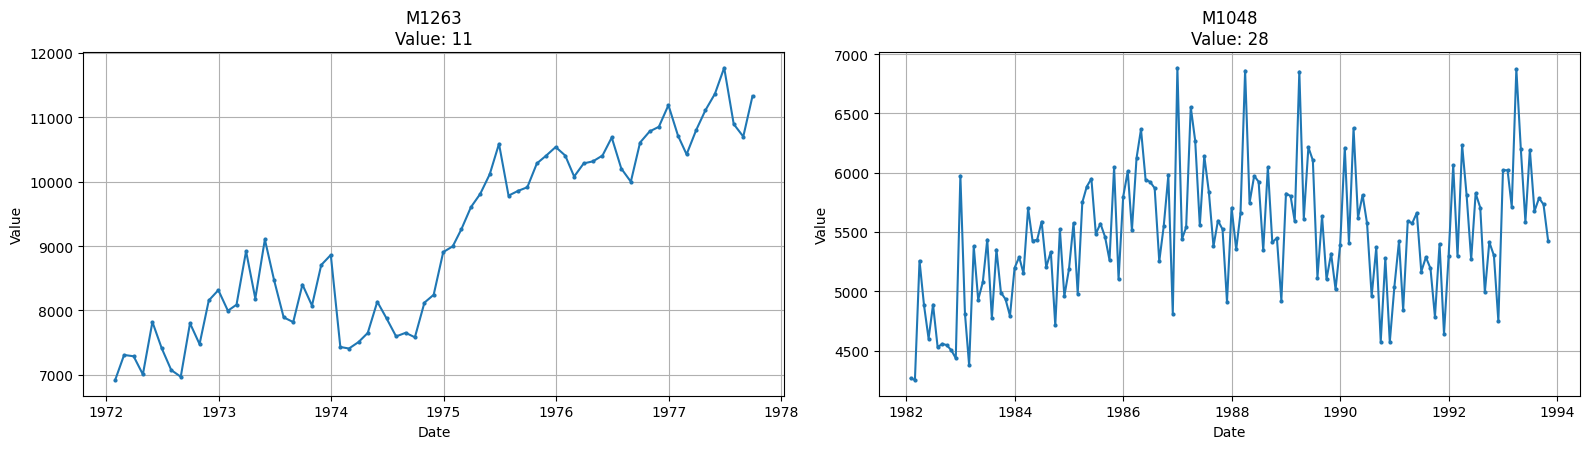

Parameter,Type,Description,Default
model,str,"Cost function model (e.g., ""l1"", ""l2"", ""rbf"")","""l2"""
custom_cost,BaseCost or None,Custom cost function object. Overrides `model`.,None
min_size,int,Minimum allowable segment length.,2
jump,int,Subsampling step size for checking breakpoints.,5
params,dict or None,Additional parameters dictionary for the cost `model`.,None


## STL_Trend_Strength

This feature computes the strength of a trend within the time-series.  
**Low value:** A value close to zero means there are few/none indicators of a trend in the time series.  
**High value:** A value close to one means there are strong signs of the series containing a trend.

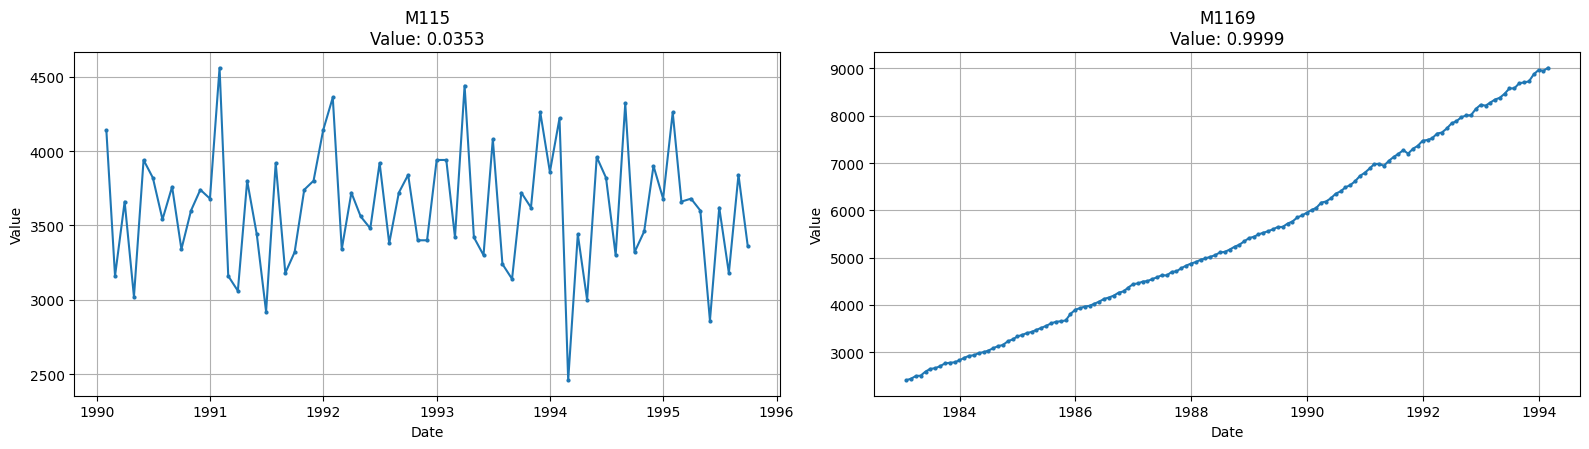

Parameter,Type,Description,Default
freq,int,"Frequency (period) of the time series (e.g., 12 for monthly).",1
seasonal,int,Length of the seasonal smoother (must be odd).,7
robust,bool,Flag for robust fitting.,False


## ACF_FirstLag

This feature measures the first autocorrelation coefficient (lag 1).  
**Low value:** A negative value indicates negative autocorrelation (tendency to oscillate).  
**High value:** A positive value indicates positive autocorrelation (tendency to persist).

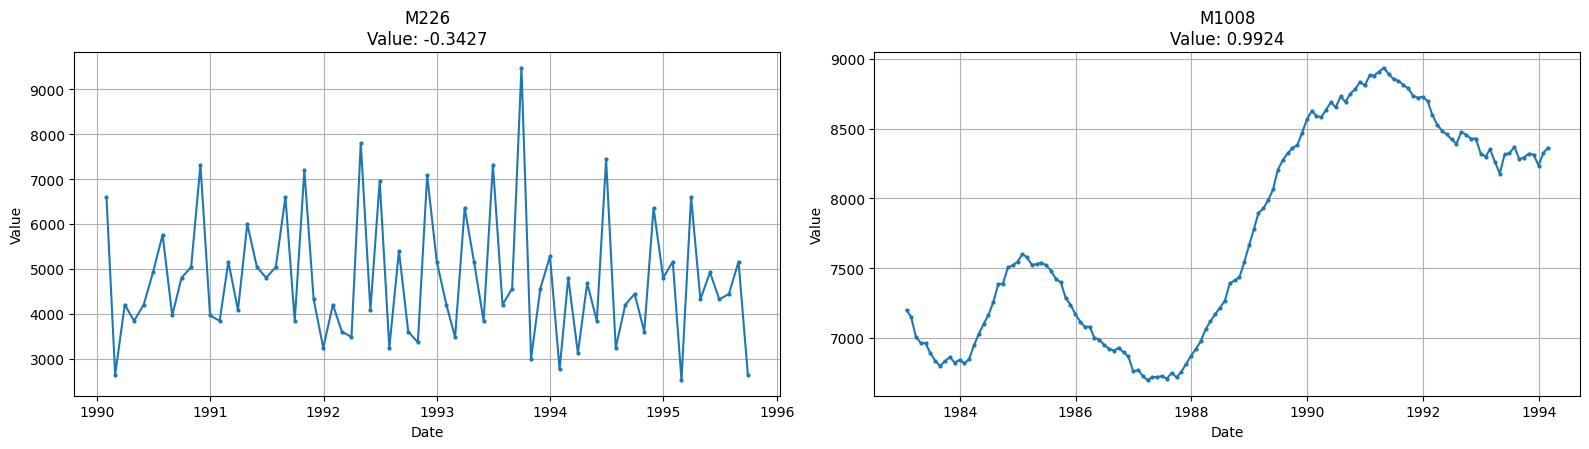

Parameter,Type,Description,Default
nlags,int,Number of lags for ACF calculation.,10


## LinearRegression_Slope

This feature measures the overall linear trend slope.  
**Low value:** A negative value means there is a downward trend.  
**High value:** A positive value means an upward trend.

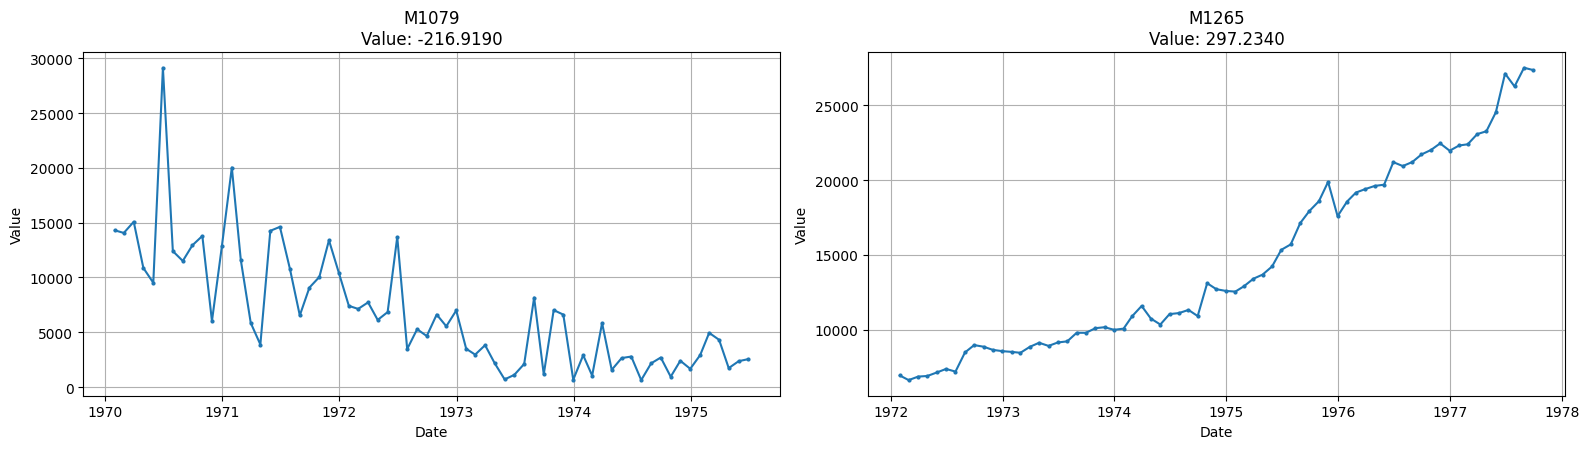

**No Parameters**

## LinearRegression_R2

This feature measures how well a linear trend fits the time-series (Coefficient of Determination, $R^2$).  
**Low value:** A value close to zero means a linear model explains little variance.  
**High value:** A value close to one means a linear model explains much of the variance.

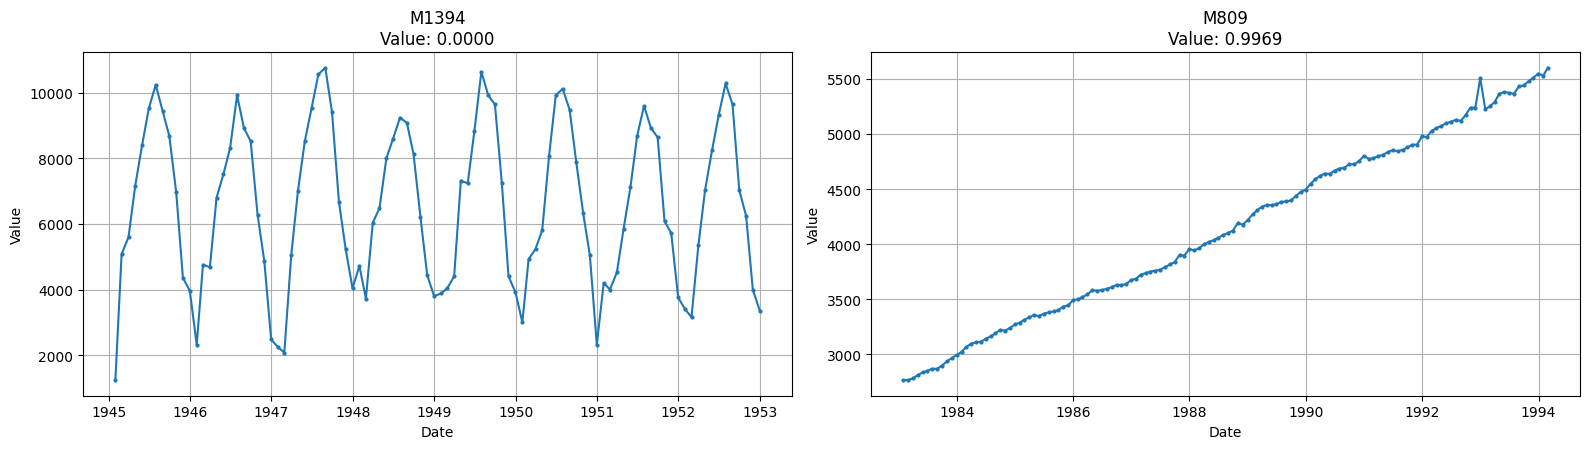

**No Parameters**

In [25]:
# Pelt Parameters
pelt_parameters = [
    {"Parameter": "model", "Type": "str", "Description": 'Cost function model (e.g., "l1", "l2", "rbf")', "Default": '"l2"'},
    {"Parameter": "custom_cost", "Type": "BaseCost or None", "Description": "Custom cost function object. Overrides `model`.", "Default": "None"},
    {"Parameter": "min_size", "Type": "int", "Description": "Minimum allowable segment length.", "Default": "2"},
    {"Parameter": "jump", "Type": "int", "Description": "Subsampling step size for checking breakpoints.", "Default": "5"},
    {"Parameter": "params", "Type": "dict or None", "Description": "Additional parameters dictionary for the cost `model`.", "Default": "None"}
]

# STLFeatures Parameters
stl_parameters = [
    {"Parameter": "freq", "Type": "int", "Description": "Frequency (period) of the time series (e.g., 12 for monthly).", "Default": "1"},
    {"Parameter": "seasonal", "Type": "int", "Description": "Length of the seasonal smoother (must be odd).", "Default": "7"},
    {"Parameter": "robust", "Type": "bool", "Description": "Flag for robust fitting.", "Default": "False"}
]

# ACF_Features Parameters
acf_parameters = [
    {"Parameter": "nlags", "Type": "int", "Description": "Number of lags for ACF calculation.", "Default": "10"}
]

# CrossingPoints Parameters
cp_parameters = [] # Empty list as CrossingPoints.__init__() now takes no arguments

# LinearRegression Parameters
lr_parameters = [] # Empty list as LinearRegression.__init__() takes no arguments

# --- Feature Parameter Mapping ---
feature_param_map = {
    "Pelt_Num_Breakpoints": pelt_parameters,
    "STL_Trend_Strength": stl_parameters,
    "ACF_FirstLag": acf_parameters,       
    "CrossingPoints": cp_parameters,      
    "LinearRegression_Slope": lr_parameters,
    "LinearRegression_R2": lr_parameters
}

# --- display_parameter_table Function ---
def display_parameter_table(parameters_list, feature_name):
    """Displays an HTML table of parameters or 'No Parameters' message."""
    if not parameters_list:
        display(Markdown("**No Parameters**"))
        return

    try:
        headers = list(parameters_list[0].keys())
        data_rows = [list(param.values()) for param in parameters_list]
    except (IndexError, AttributeError):
         print(f"\nError formatting parameters for {feature_name}.")
         return

    html_table = tabulate(data_rows, headers=headers, tablefmt="html")
    display(HTML(html_table))

# --- Main Analysis Loop ---
if 'extreme_datasets_info' in locals() and extreme_datasets_info is not None and 'Y_df' in locals() and Y_df is not None:

    for feature_name, details in extreme_datasets_info.items():
        # --- Feature Name Title ---
        display(Markdown(f"## {feature_name}"))

        # --- Data Setup ---
        ids_to_process = {
            "Lowest Value": details["low_id"],
            "Highest Value": details["high_id"]
        }
        base_calculator = details["calculator"]
        params = details["params"] # Instance specific params (not directly used in this visualization part)

        # --- Feature Description ---
        if feature_name == "Pelt_Num_Breakpoints":
             display(Markdown(f"This feature detects the number of points where the trend changes.  \n**Low value:** The trend has few/none shifting points, and is constant through time.  \n**High value:** The trend is constantly shifting, provoking many structural changes."))
        elif feature_name == "STL_Trend_Strength":
             display(Markdown(f"This feature computes the strength of a trend within the time-series.  \n**Low value:** A value close to zero means there are few/none indicators of a trend in the time series.  \n**High value:** A value close to one means there are strong signs of the series containing a trend."))
        elif feature_name == "ACF_FirstLag":
             display(Markdown(f"This feature measures the first autocorrelation coefficient (lag 1).  \n**Low value:** A negative value indicates negative autocorrelation (tendency to oscillate).  \n**High value:** A positive value indicates positive autocorrelation (tendency to persist)."))
        # Add elif for CrossingPoints if used
        # elif feature_name == "CrossingPoints":
        #     display(Markdown(f"This feature counts the number of times the series crosses its median value."))
        elif feature_name == "LinearRegression_Slope":
             display(Markdown(f"This feature measures the overall linear trend slope.  \n**Low value:** A negative value means there is a downward trend.  \n**High value:** A positive value means an upward trend."))
        elif feature_name == "LinearRegression_R2":
             display(Markdown(f"This feature measures how well a linear trend fits the time-series (Coefficient of Determination, $R^2$).  \n**Low value:** A value close to zero means a linear model explains little variance.  \n**High value:** A value close to one means a linear model explains much of the variance."))

        # --- Plotting Setup ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        feature_values = {}

        # --- Inner loop for plotting Low and High ---
        for i, (desc, target_id) in enumerate(ids_to_process.items()):
            # (Keep data loading, validation, feature calculation, and plotting logic as is)
            # ... (previous inner loop code) ...
            ax = axes[i]
            if 'Y_df' not in locals() or Y_df is None: print("Error: Y_df DataFrame not found."); ax.set_title(f"{target_id} (Dataframe Error)"); break
            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')
            if series_df.empty: print(f"Dataset {target_id} empty."); ax.set_title(f"{target_id} (Data missing)"); ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center', transform=ax.transAxes); continue
            series_np = series_df['y'].to_numpy()
            if len(series_np) < 2: print(f"Dataset {target_id} too short."); ax.set_title(f"{target_id} (Too short)"); ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center', transform=ax.transAxes); continue

            feature_value = np.nan
            current_calculator = base_calculator

            # --- Feature Calculation Logic ---
            if feature_name == "Pelt_Num_Breakpoints":
                min_len_pelt = getattr(current_calculator, 'min_size', 2)
                if len(series_np) >= min_len_pelt and len(series_np) > 1: pen_value = np.log(len(series_np)); current_calculator.fit(series_np); bkps = current_calculator.predict(pen=pen_value); num_changepoints = len(bkps) - 1 if bkps else 0; feature_value = max(0, num_changepoints)
                else: print(f"Skipping Pelt for {target_id}")
            elif feature_name == "STL_Trend_Strength":
                freq = getattr(current_calculator, 'freq', 1); min_len_stl = 2 * freq + 1 if freq > 1 else 2
                if len(series_np) >= min_len_stl: stl_result = current_calculator.get_features(x=series_np); feature_value = stl_result.get('trend', np.nan)
                else: print(f"Skipping STL for {target_id} (len {len(series_np)} < {min_len_stl})")
            elif feature_name == "ACF_FirstLag":
                 acf_result = current_calculator.get_features(x=series_np); feature_value = acf_result.get('x_acf1', np.nan)
            # Add elif for CrossingPoints if used
            # elif feature_name == "CrossingPoints":
            #     cp_result = current_calculator.get_features(x=series_np.astype(float)); feature_value = cp_result.get('crossing_points', np.nan)
            elif feature_name == "LinearRegression_Slope":
                 lr_model = LinearRegression();
                 try: lr_model.fit(time_series=series_np); feature_value = lr_model.coef_
                 except ValueError as e: print(f"LR fit failed for {target_id}: {e}")
            elif feature_name == "LinearRegression_R2":
                 lr_model = LinearRegression();
                 try: lr_model.fit(time_series=series_np); feature_value = lr_model.score()
                 except ValueError as e: print(f"LR fit failed for {target_id}: {e}")

            feature_values[desc] = feature_value

            # --- Plotting ---
            ax.plot(series_df['ds'], series_np, marker='.', linestyle='-', markersize=4)
            subplot_title = f"{target_id}"
            if feature_value is not None and not np.isnan(feature_value):
                if feature_name == "Pelt_Num_Breakpoints": subplot_title += f"\nValue: {int(feature_value)}"
                else: subplot_title += f"\nValue: {feature_value:.4f}"
            else: subplot_title += f"\nValue: Calc Failed/Skipped"
            ax.set_title(subplot_title); ax.set_xlabel("Date"); ax.set_ylabel("Value"); ax.grid(True)
        # --- End Inner loop ---

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show() # Show the plots

        # --- Display Parameter Table AFTER plots ---
        # Use the feature_param_map which now points to the CORRECTED lists
        if feature_name in feature_param_map:
            param_list_for_feature = feature_param_map[feature_name]
            display_parameter_table(param_list_for_feature, feature_name)
        else:
            print(f"Parameter table definition not found for {feature_name}")
        # --- End Parameter Table ---

        # Separator line removed as requested

    # --- End Outer loop ---

else:
     print("Analysis loop skipped: 'extreme_datasets_info' or 'Y_df' not defined or is None.")